# Colab Notebook for experiments on BigGAN generator & GAN inversion

# Setups & Installs

In [ ]:
!pip install pytorch-pretrained-biggan

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
imagenet_path_drive = "/content/drive/MyDrive/Colab Notebooks/CV/project/imagenet"
path_drive = "/content/drive/MyDrive/Colab Notebooks/CV/project/"

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import nltk
nltk.download('wordnet')

import matplotlib.pyplot as plt
import pickle 
from tqdm import tqdm
import torch

from colornet_dataset import INColorDataset, get_dataloader
from colornet import ColorNet, ColorNetInv

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

# Getting Data

In [ ]:

%mkdir imagenet 
%cd imagenet 
!tar -xvf "/content/drive/MyDrive/Colab Notebooks/CV/project/ILSVRC2012_img_val.tar"
%cd /content

# Model

In [ ]:
###
# standard training loop
###
def train_model(model, target, data, input, optimizer, scheduler = None, num_steps=10000):
    """
    "input" is the latent vector we optimize on
    """
    model.train()
    
    #take in a random image
    
    g = data[0].to(device)
    c = data[1].to(device)
    gt = data[2].to(device)

    losses = []

    iterator =  tqdm(range(num_steps))
    for step in iterator:

        # zero the parameter gradients
        optimizer.zero_grad()

        #forward pass
        out = model(input, gt)

        #transform output to grayscale
        out_g = transforms.Grayscale(num_output_channels=1)(out)

        #compute loss
        loss = nn.MSELoss()(out_g, g)

        #backprop on "input"
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()
        
        iterator.set_description("Current Loss ({:.4e})".format(
              loss.item()
          )
        )
        losses.append(loss.item)
    
    pickle.dump(losses, open(path_drive + f"ganinv/ganinv_{target}_loss.pkl", 'wb'))
    pickle.dump(input.clone().cpu(), open(path_drive + f"ganinv/ganinv_{target}.pkl", 'wb'))
    
    return input

# Model Testing

In [ ]:
#Assembling Data
dl = get_dataloader("5k", 128, "test", batch_size=1, num_workers=1)

colornet = ColorNetInv().to(device)

g_arr = []
c_arr = []
gt_arr = []

for g, c, gt in dl:
    g_arr.append(g)
    c_arr.append(c)
    gt_arr.append(gt)

In [ ]:
target = 5 #Change this number to try on other pictures
data = [g_arr[target], c_arr[target], gt_arr[target]]

input = torch.randn((1,128)).to(device)
input.requires_grad = True
optimizer = torch.optim.Adam([input], lr = 0.005, betas = (0.5, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5000, gamma = 0.1)

In [ ]:
input = train_model(colornet, target, data, input, optimizer, scheduler = None, num_steps=10000)

Current Loss (1.8991e-02): 100%|██████████| 10000/10000 [16:17<00:00, 10.23it/s]


# Evaluation

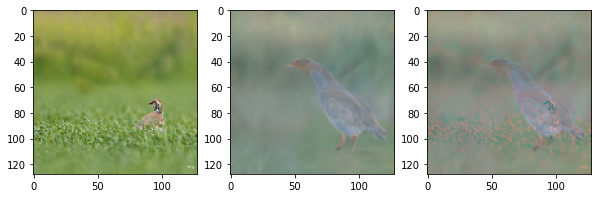

In [ ]:
g = data[0].to(device)
c = data[1].to(device)
gt = data[2].to(device)
            
out = None
with torch.no_grad():
    out = colornet(input, gt)
    
    g = g.repeat(1,3,1,1)
    
    g_LAB = rgb_to_lab(g)
    out_LAB = rgb_to_lab(out)

    out_LAB[:, [0], :, :] = g_LAB[:, [0], :, :]

    final = lab_to_rgb(out_LAB)


fig, ax = plt.subplots(1,3, figsize=(10,30))
ax[0].imshow(c[0].detach().cpu().numpy().transpose(1,2,0))
ax[1].imshow(out[0].detach().cpu().numpy().transpose(1,2,0))
ax[2].imshow(final[0].detach().cpu().numpy().transpose(1,2,0))